<a href="https://colab.research.google.com/github/sakhnos/Wabs-Wsc/blob/master/Wabs(t).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a

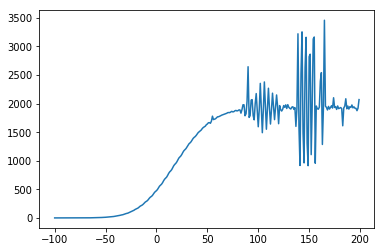

In [14]:
%reset -f 
import numpy as np
import math
import scipy
from scipy.integrate import odeint
#from numpy import linspace, array
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter  
from scipy.integrate import quad  

def EGauss(t, w0, tau, E0, phi):
  return E0 * np.exp(-t ** 2 / (2 * tau ** 2)) * np.cos(w0*t + phi)


def IntSquared(t, w, w0, tau, E0, phi):
  tt = np.arange(-2000, t, 1)                # Small step rises time of calculation extremly! 
  Jn = np.zeros(len(tt), dtype = np.complex64)  # https://docs.scipy.org/doc/numpy/user/basics.types.html       np.csingle
  for i in range(len(Jn)):
    Jn[i] = np.exp(1j * w * tt[i]) * EGauss(tt[i], w0, tau, E0, phi)
  integral = np.trapz(Jn, tt)
  return (np.abs(integral)) ** 2


def IntSquaredSciPy(t, w, w0, tau, E0, phi):  
  
  def func(tt, w, w0, tau, E0, phi):
    return np.exp(1j * w * tt) * EGauss(tt, w0, tau, E0, phi) 
  
  def func_real(tt, w, w0, tau, E0, phi):
        return scipy.real(func(tt, w, w0, tau, E0, phi))
    
  def func_imag(tt, w, w0, tau, E0, phi):
        return scipy.imag(func(tt, w, w0, tau, E0, phi))
  
  J_real = quad(func_real, -2000, t, args = (w, w0, tau, E0, phi) )   # (tt, w, w0, tau, E0, phi)
  J_imag = quad(func_imag, -2000, t, args = (w, w0, tau, E0, phi) )   # (tt, w, w0, tau, E0, phi) 
  return (np.abs(J_real[0] + J_imag[0])) ** 2 



def IntSquared_visualisationSciPy():
  t = np.arange(-100, 200, 1)
  JJ = np.zeros(len(t))
  w = 2.48
  w0 = 2.48
  tau = 35
  E0 = 1
  phi = 0
  
  for i in range(len(JJ)):
    JJ[i] = IntSquaredSciPy(t[i], w, w0, tau, E0, phi)
  plt.plot(t, JJ)
  plt.show()
IntSquared_visualisationSciPy() 



# def IntSquared_visualisation():
#   t = np.arange(-100, 200, 2)
#   JJ = np.zeros(len(t))
#   w = 2.48
#   w0 = 2.46
#   tau = 48
#   E0 = 1
#   phi = 0
#   for i in range(len(JJ)):
#     JJ[i] = IntSquaredSciPy(t[i], w, w0, tau, E0, phi)
#   plt.plot(t, JJ)
#   plt.show()
#IntSquared_visualisation() 
                 

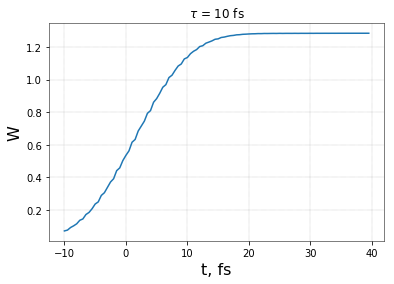

In [3]:
aB = 0.052 # Bohr's radius in nm
c = 137    # speed of light, at. u.
### PLASMON's parameters (Na8-cluster) ######
wp = 2.48 / 27.2 # eV, resonant freq of plasmon Na8
G = 0.248 / 27.2 # gamma Na8, q = 10
R = 0.4 / aB     # radius of cluster, nm
#############################################

def alpha(w, wp, R, G):   # dynamic polarizability
  a = R ** 3 * wp ** 2 / (wp ** 2 - w ** 2 - 1j * w * G)
  return a

def sigma_abs(w, wp, R, G):
  cross_abs = 4 * np.pi * w * np.imag(alpha(w, wp, R, G)) / c   # Optical theorem, p. 184 VA
  return  cross_abs 

def cross_visualisation():
    w = np.arange(0, 6, 0.01) / 27.2
    sigma = np.zeros(len(w))
    for i in range (len(w)):
       sigma[i] = sigma_abs(w[i], wp, R, G)
    plt.plot(w * 27.2, sigma)
    plt.show()
    
def Gauss_visualisation():
    t = np.arange(-20, 20, 0.1)
    w0 = 2.4
    tau = 2    
    sigma = np.zeros(len(t))
    for i in range (len(t)):
       sigma[i] = EGauss(t[i], w0, tau, 1, 0)
    plt.plot(t, sigma)
    plt.show()
     
#Gauss_visualisation()    
#cross_visualisation() 

def W(t, tau, w0, E0, phi):
  ww = np.arange(0.1, 5, 0.1) / 27.2
  J = np.zeros(len(ww))
  for i in range (len(ww)):
    J[i] = sigma_abs(ww[i], wp, R, G) * IntSquared(t / 0.024, ww[i],  w0 / 27.2, tau / 0.024, E0, phi) / ww[i] 
  integral =  (c / (4 * np.pi ** 2) ) * np.trapz(J, ww)   
  return integral 

def W_visualisation():            
  t = np.arange(-10, 40, 0.5) # abscissa, fs         
  Wabs = np.zeros(len(t)) 
  tau =10                   # pulses's duration, fs
  E0 = 10 ** -3              # electric field strength, at. u.
  phi = 0                     
  w0 = 2.42                  # GP carrier frequency
  # plasmon's parameters see above
  for i in range (len(t)):
       Wabs[i] = W(t[i], tau, w0, E0, phi)
  fig = plt.figure()
  fig.patch.set_facecolor('xkcd:white') # outer color        
  plt.plot(t, Wabs)   
  ax = plt.gca()
  ax.set_facecolor((1.0, 1.0, 1.0))    # background color
  ax.spines['bottom'].set_linewidth(0.5)
  ax.spines['bottom'].set_color('0.0') 
  ax.spines['top'].set_linewidth(0.5)
  ax.spines['top'].set_color('0.0') 
  ax.spines['left'].set_linewidth(0.5)
  ax.spines['left'].set_color('0.0') 
  ax.spines['right'].set_linewidth(0.5)
  ax.spines['right'].set_color('0.0') 
  ax.grid(b=True, which='major', axis='both', color = 'k', linestyle=':', linewidth=0.2)
  plt.xlabel(r't, fs',  {'color': 'k', 'fontsize': 16})
  plt.ylabel(r'W', {'color': 'k', 'fontsize': 16})
  plt.title(r'$\tau$ = ' + str(tau) + " fs") 
  plt.ticklabel_format(style='sci', axis='y', scilimits=(2, 3), useOffset=False)
  plt.show()
          
W_visualisation()    